In [1]:
import h5py
import librosa
import mir_eval
import numpy as np
import os
import pandas as pd
import peakutils
import scipy.signal
import soundfile as sf
import sys
sys.path.append('../src')
import localmodule

In [2]:
# Define constants.
data_dir = localmodule.get_data_dir()
dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_units = len(units)
trials = [5, 7, 9, 7, 7, 8] # maximize clip-wise val acc
icassp_thresholds = 1.0 - np.logspace(-9, 0, 181)[::-1]
n_thresholds = len(icassp_thresholds)
tolerance = 0.5 # in seconds


# Define directory for model.
test_unit_id = 1
aug_str = "all"
model_name = "icassp-convnet"
if not aug_str == "none":
    model_name = "_".join([model_name, "aug-" + aug_str])
model_dir = os.path.join(models_dir, model_name)


# Define directory for annotations.
annotations_name = "_".join([dataset_name, "annotations"])
annotations_dir = os.path.join(data_dir, annotations_name)


# Pick the highest threshold.
threshold = icassp_thresholds[139] # 139 is the optimal threshold


# Load prediction.
test_unit_str = units[test_unit_id]
unit_dir = os.path.join(model_dir, test_unit_str)
trial_id = trials[test_unit_id]
trial_str = "trial-" + str(trial_id)
trial_dir = os.path.join(unit_dir, trial_str)
prediction_name = "_".join([
    dataset_name,
    model_name,
    "test-" + test_unit_str,
    trial_str,
    "predict-" + test_unit_str,
    "full-predictions.csv"])
prediction_path = os.path.join(trial_dir, prediction_name)
prediction_df = pd.read_csv(prediction_path)
odf = np.array(prediction_df["Predicted probability"])
timestamps = np.array(prediction_df["Timestamp"])


# Select peaks.
peak_locations = peakutils.indexes(odf, thres=threshold, min_dist=3)
selected = timestamps[peak_locations]


# Load annotation.
annotation_path = os.path.join(annotations_dir,
    test_unit_str + ".txt")
annotation = pd.read_csv(annotation_path, '\t')
begin_times = np.array(annotation["Begin Time (s)"])
end_times = np.array(annotation["End Time (s)"])
relevant = 0.5 * (begin_times + end_times)
relevant = np.sort(relevant)
n_relevant = len(relevant)


# Match events.
selected_relevant = mir_eval.util.match_events(
    relevant, selected, tolerance)
tp_relevant_ids = list(zip(*selected_relevant))[0]
tp_relevant_times = [relevant[i] for i in tp_relevant_ids]
tp_selected_ids = list(zip(*selected_relevant))[1]
tp_selected_times = [selected[i] for i in tp_selected_ids]


# List false alarms
fp_times = [selected[i] for i in range(len(selected))
    if i not in tp_selected_ids]


# List missed detections
fn_times = [relevant[i] for i in range(len(relevant))
    if i not in tp_relevant_ids]

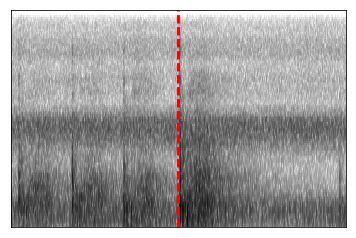

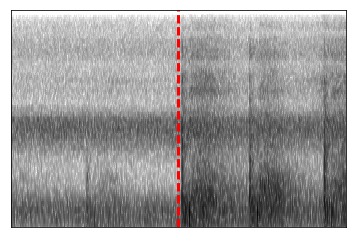

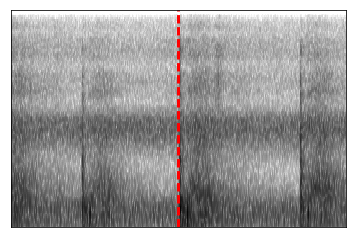

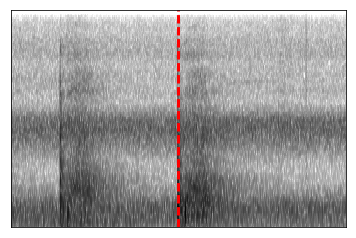

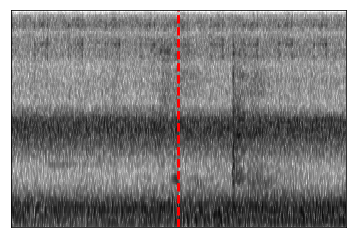

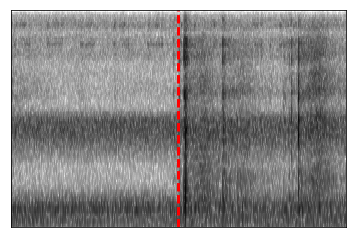

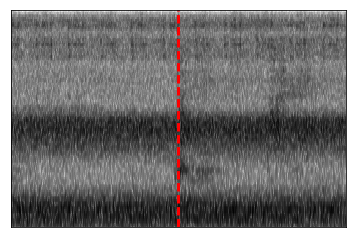

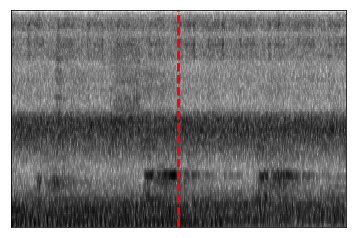

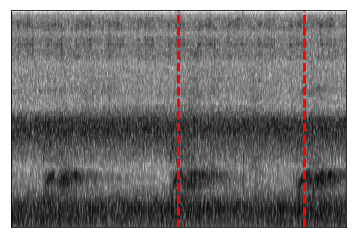

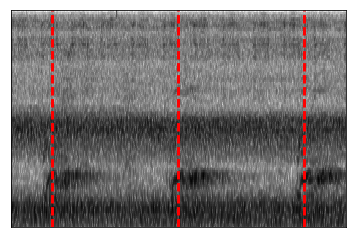

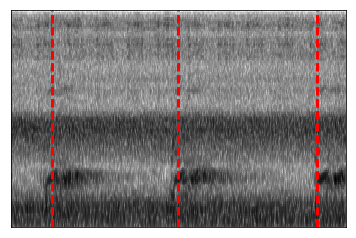

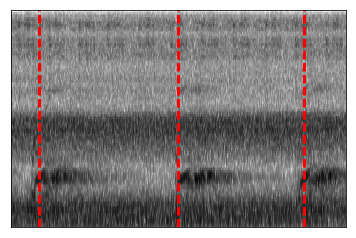

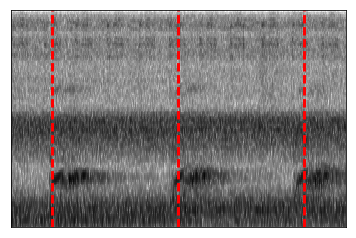

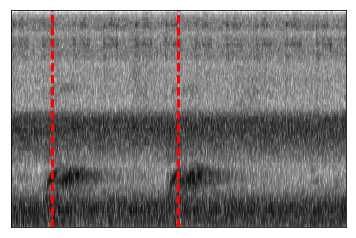

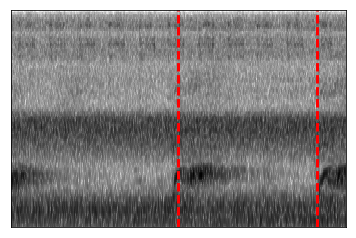

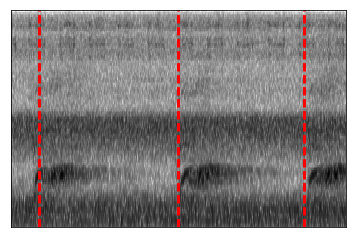

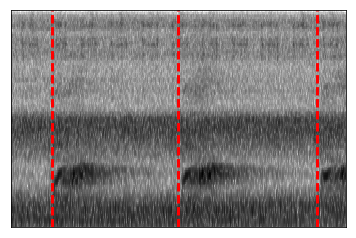

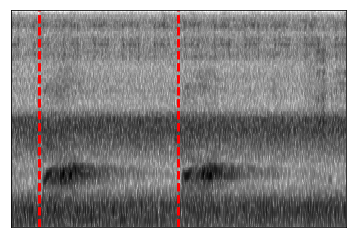

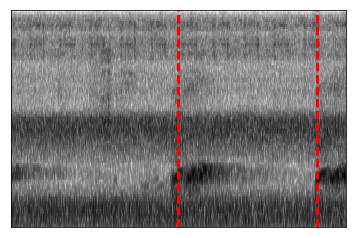

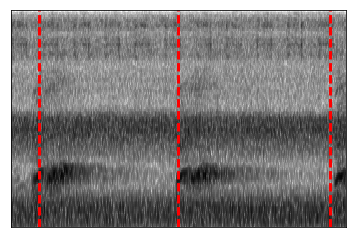

In [3]:
# Load log-mel-spectrogram (lms).
data_dir = localmodule.get_data_dir()
lms_dir = os.path.join(data_dir, "BirdVox-70k_full-logmelspec")
lms_path = os.path.join(lms_dir, test_unit_str + ".hdf5")
lms_file = h5py.File(lms_path)
lms_dataset = lms_file["logmelspec"]
lms_settings = lms_file["logmelspec_settings"]
lms_sr = lms_settings["sr"].value
hop_length = lms_settings["hop_length"].value


import librosa
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from librosa import display


half_window_duration = 1.0

for window_midpoint in fp_times[:20]:
    lms_midpoint = int(window_midpoint * (lms_sr/hop_length))
    lms_start = lms_midpoint - int(half_window_duration*lms_sr/hop_length)
    lms_stop = lms_midpoint + int(half_window_duration*lms_sr/hop_length)
    lms = lms_dataset[:, lms_start:lms_stop]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    librosa.display.specshow(lms, cmap="gray_r")
    
    window_start = window_midpoint - half_window_duration
    window_stop = window_midpoint + half_window_duration
    windowed_relevant = [r for r in relevant if (r>window_start) and (r<window_stop)]
    windowed_selected = [s for s in selected if (s>window_start) and (s<window_stop)]
    window_tp = mir_eval.util.match_events(relevant, selected, tolerance)
    
    half_rect_width = int(0.5 * lms_sr / hop_length)
    
    for r in windowed_relevant:
        relevant_x = int((half_window_duration-window_midpoint+r)*lms_sr/hop_length)
        plt.plot([relevant_x]*2, [0, 128], color="blue", linewidth=3)
        rect = matplotlib.patches.Rectangle(
            (relevant_x - half_rect_width, 0), 
            2*half_rect_width, 128, color="blue", alpha=0.2)
        ax.add_patch(rect)
    
    
    for s in windowed_selected:
        selected_x = int((half_window_duration-window_midpoint+s)*lms_sr/hop_length)
        if s in tp_selected_times:
            plt.plot([selected_x]*2, [0, 128], '--', color="green", linewidth=3)
        elif s in fp_times:
            plt.plot([selected_x]*2, [0, 128], '--', color="red", linewidth=3)


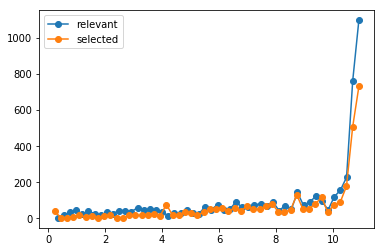

In [110]:
relevant_x, relevant_y = np.histogram(relevant, bins=50);
selected_x, selected_y = np.histogram(selected, bins=50);
false_alarms_x, false_alarms_y = np.histogram(false_alarms, bins=50);
plt.plot(relevant_y[1:] / 3600, relevant_x, '-o', label="relevant")
plt.plot(selected_y[1:] / 3600, selected_x, '-o', label="selected")
plt.legend()

In [108]:
relevant

array([   415.728     ,    910.892     ,   1029.387     , ...,
        39289.16373885,  39290.64893793,  39291.18569409])

In [51]:
list(lms_file["logmelspec_settings"].keys())

['fmax', 'fmin', 'hop_length', 'n_fft', 'n_mels', 'sr', 'win_length', 'window']